### Analysis of variance (ANOVA) is a statistical technique that is used to check if the means of two or more groups are significantly different from each other. ANOVA checks the impact of one or more factors by comparing the means of different samples.

Types of ANOVA(Analysis of variance):
1. One way analysis
2. Two way analysis
3. K-way analysis

ANOVA Assumptions:
- cases are independent
- Distributions are normal
- Variance of data in groups is homogeneous

### History

*ANOVA was initially suggested by the British statistician Sir Ronald Aylmer Fisher in the 1920s. He coined the phrase "analysis of variance," defined as "the separation of variance ascribable to one group of causes from the variance ascribable to the other groups."1*

*Fisher was very interested in genetics. ANOVA uses Fisher's F-distribution as part of the test of statistical significance. Some of his famous papers include "On the mathematical foundations of theoretical statistics", published in the Philosophical Transactions of the Royal Society in 1922, and "Applications of Student's distribution" , published in 1925.*

### Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat

### Load the Dataset

In [2]:
df = pd.read_csv("C:/Users/S_The/Downloads/onewayanova.txt", sep="\t")
# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
# replace column names
df_melt.columns = ['index', 'treatments', 'value']





**Generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences between different treatments**

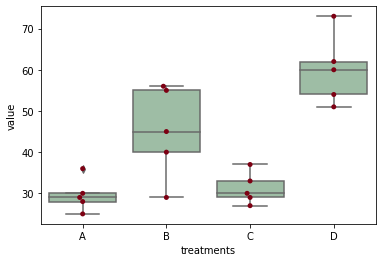

In [3]:
ax = sns.boxplot(x='treatments', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="treatments", y="value", data=df_melt, color='#7d0013')
plt.show()

**Stats f_oneway functions takes the groups as input and returns ANOVA F and p value**

In [4]:
fvalue, pvalue = stats.f_oneway(df['A'], df['B'], df['C'], df['D'])
print(fvalue, pvalue)

17.492810457516338 2.639241146210922e-05


**Ordinary Least Squares (OLS) model**

In [5]:
model = ols('value ~ C(treatments)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),3010.95,3.0,17.49281,0.000026
Residual,918.00,16.0,NaN,NaN


**ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)**

In [6]:
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),3.0,3010.95,1003.650,17.49281,0.000026
Residual,16.0,918.00,57.375,NaN,NaN


### Note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares(typ parameter) will produce similar results.

### Interpretation

*The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among treatments.*

From ANOVA analysis, we know that treatment differences are statistically significant, but ANOVA does not tell which treatments are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (post hoc comparison) analysis for all unplanned comparison using Tukey’s honestly significantly differenced (HSD) test.

- we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
- perform multiple pairwise comparison (Tukey's HSD)
- unequal sample size data, tukey_hsd uses Tukey-Kramer test

In [15]:
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='treatments', anova_model='value ~ C(treatments)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,15.4,1.692871,29.107129,4.546156,0.025070
1,A,C,1.6,-12.107129,15.307129,0.472328,0.900000
2,A,D,30.4,16.692871,44.107129,8.974231,0.001000
3,B,C,13.8,0.092871,27.507129,4.073828,0.048178
4,B,D,15.0,1.292871,28.707129,4.428074,0.029578
5,C,D,28.8,15.092871,42.507129,8.501903,0.001000


### Test ANOVA assumptions

**ANOVA assumptions can be checked using test statistics (e.g. Shapiro-Wilk, Bartlett’s, Levene’s test) and the visual approaches such as residual plots (e.g. QQ-plots) and histograms.**

Now, I will generate QQ-plot from standardized residuals (outliers can be easily detected from standardized residuals than normal residuals)

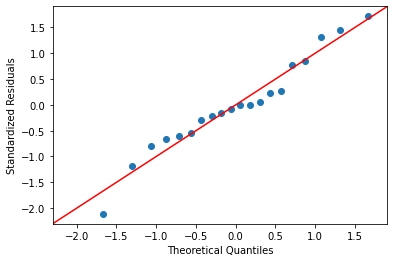

In [7]:
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

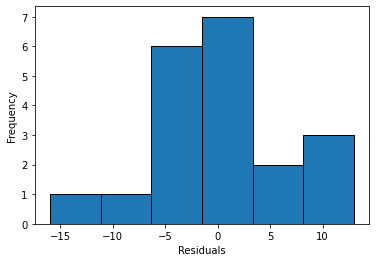

In [8]:
# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In the histogram, the distribution looks approximately normal and suggests that residuals are approximately normally distributed

### Shapiro-Wilk test can be used to check the normal distribution of residuals. Null hypothesis: data is drawn from normal distribution.

In [9]:
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.9685019850730896 0.7229772806167603


As the p value is non significant, we fail to reject null hypothesis and conclude that data is drawn from normal distribution

As the data is drawn from normal distribution, use Bartlett’s test to check the Homogeneity of variances. Null hypothesis: samples from populations have equal variances.

In [10]:
w, pvalue = stats.bartlett(df['A'], df['B'], df['C'], df['D'])
print(w, pvalue)

5.687843565012841 0.1278253399753447


In [11]:
res = stat()
res.bartlett(df=df_melt, res_var='value', xfac_var='treatments')
res.bartlett_summary

,Parameter,Value
0,Test statistics (T),5.6878
1,Degrees of freedom (Df),3.0000
2,p value,0.1278


As the p value (0.12) is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.

### Levene’s test can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

In [12]:
res = stat()
res.levene(df=df_melt, res_var='value', xfac_var='treatments')
res.levene_summary

,Parameter,Value
0,Test statistics (W),1.9220
1,Degrees of freedom (Df),3.0000
2,p value,0.1667


## Conclusion

ANOVA-based approaches require at least interval data for the dependent variable.